# ResNet50

<a id='top'.</a>
[Table of contents](#bottom)

- [Introduction](#intro)
    - [Data loading](#dl)<a id='dl'.</a>
    - [Data augmentation](#da)<a id='da'.</a>

- [Modeling](#mobilenet)
    - [Base model](#dl)<a id='dl'.</a>
    - [Generating features](#dl)<a id='dl'.</a>
    - [Top model](#dl)<a id='dl'.</a>
    
[Table of contents](#top) [Bottom](#bottom)

<a id='intro'.</a>

### Introduction

In [1]:
import sys
sys.path.append('../utils/')

import libraries
from libraries import *
import utils
from utils import *

%matplotlib inline

reload(libraries)
from libraries import *

# checking
print(get_available_gpus())
print(psutil.virtual_memory())
print(keras.__version__)

Using TensorFlow backend.


[]
svmem(total=17179869184, available=8942944256, percent=47.9, used=8285360128, free=7534501888, active=3799695360, inactive=1408442368, wired=3077222400)
2.0.8


#### Data loading

In [8]:
if not os.path.exists('../output'): os.mkdir('../output')

model = 'resnet_50'
target_size = (512, 512)
target_size_rn50 = (224, 224)
num_classes = 1
input_shape = target_size + (3,)
input_shape_rn050 = target_size_rn50 + (3,)

path='../../data/sushi_or_sandwich/'

In [5]:
x_train, y_train, x_test, y_test, mean_set, std_set = load_data(split=0.8, path=path, target_size=target_size)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, mean_set, std_set)

FileNotFoundError: [Errno 2] No such file or directory: '../output/compressed_data'

In [ ]:
# checking
print(timeit.timeit(load_data(path=path), number=1))
print(timeit.timeit(load_data(path=path, pil=True), number=1))

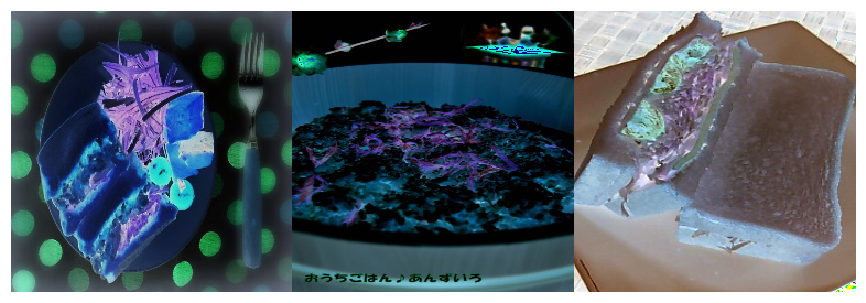

[0.0, 1.0, 0.0]


In [20]:
plot_images(x_train[:12]); print(list(y_train[:12]))

In [35]:
# visualizing what the loading process already does: 

x_train_r = x_train / 255
x_test_r = x_test / 255

x_train_n = (x_train_r - mean_set) / std_set
x_test_n = (x_test_r - mean_set) / std_set

print(x_test.min(), x_test.max(), x_test.mean(), x_test.std())
print(x_test_r.min(), x_test_r.max(), x_test_r.mean(), x_test_r.std())
print(x_test_n.min(), x_test_n.max(), x_test_n.mean(), x_test_n.std())

0.0 255.0 136.214228217 73.0760020622
0.0 1.0 0.534173443987 0.286572557107
-1.86153451808 -1.84765144887 -1.85411855119 0.00397850664274


[Table of contents](#top) [Bottom](#bottom)

## Data augmentation

The process of data augmentation is performed by the following function contained in utils.py. It generates a set of ~2000 different data augmentation generators by iterating over an customizable value range for the following parameters/functions provided by the keras within the DataImageGenerator class:
- rotation_range
- width_shift_range     
- height_shift_range      
- shear_range             
- zoom_range              
- channel_shift_range        
- zca_whitening
- fill_mode                  
horizontal_flip=1, 
vertical_flip=1, 

Additionally it performs cropping of the images through the 'preprocessing_function'.

An example  of the images produced by a randomly selected generator is shown below.

Found 800 images belonging to 2 classes.


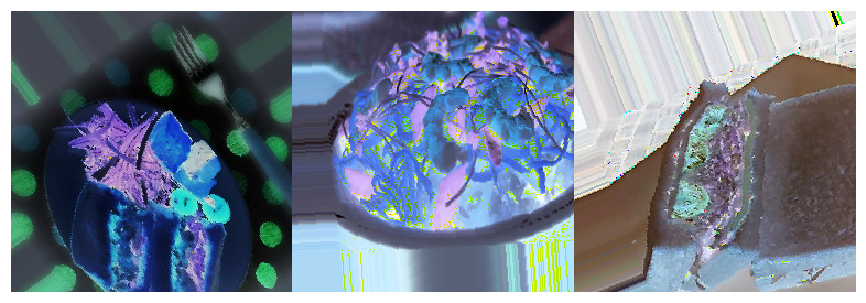

In [33]:
# 1. setting generators
ad_gens = aug_data_generators(model)

# 2. saving a 120-image sample and plotting a sample
save_aug_data_sample(ad_gens, input_shape, path)

gen = ad_gens
sample = np.empty(((0,) + input_shape))
for i, j in gen.flow_from_directory(join(path), batch_size=3, seed=0):

    sample = np.append(sample, i, axis=0); 
    sample_lab = j
    break

plot_images(sample)

[Table of contents](#top) [Bottom](#bottom)

## Modelling

##### 0.0. Setting the base model

In [39]:
if not os.path.exists(model): os.mkdir(model)

input_shape = x_train.shape[1:]

bm = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

##### 0.1. Generating features

In [41]:
# calculates the features/output of the selected base model

data={'x_train':x_train, 'y_train':y_train, 'x_test':x_test, 'y_test':y_test}

x_adf_train, y_adf_train, x_adf_test, y_adf_test = \
generate_aug_data_features(bm, ad_gens, data, output_folder=model, batch_size=16, iters=1)

print(x_adf_train.shape, y_adf_train.shape, x_adf_test.shape, y_adf_test.shape)

IndexError: too many indices for array

Total number of generators:  120


##### 0.2. Setting and training a top model

In [ ]:
# setting up optimizers:
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam()

# setting callbacks
callback = []

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
callback.append(checkpoint)

In [60]:
# dropout percentage
p = 0.5

top_m = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1, activation='sigmoid')])

# top_m.load_weights(join(model, 'top_m_675_060.h5'))

top_m.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', recall, precision, fmeasure])


model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)

# top_m.evaluate(x_adf_test, y_adf_test, batch_size=batch_size)

In [61]:
top_m.optimizer.lr = 0.000001; print(top_m.optimizer.lr)

batch_size = 128
epochs = 1

top_m_h = top_m.fit(x_adf_train, y_adf_train, batch_size=batch_size, epochs=epochs,                  
                    validation_data=(x_adf_test, y_adf_test),
                    callbacks=callbacks)

18176/19200 [===========================>..] - ETA: 0s

[0.60463694413503011,
 0.67458333333333331,
 0.57085366388161973,
 0.67412345767021176,
 0.61180227180322011]

In [88]:
# plot_hist(top_m_h, 'loss')
metrics = ['val_loss', 'val_acc', 'val_recall', 'val_precision', 'val_fmeasure']
# logfor i in metrics: 
# log = {'acc': val_acc, '': , '': , }
# l = top_m_h.history['acc']
# log.append(l)
# log

empty = []*5
empty
dict(i for i in zip(metrics, empty))

{}

In [52]:
top_m.save_weights(join(model, 'top_m_675_060.h5'))

##### 0.2.1. Setting and training alternative top models

In [30]:
p = 0.2

top_m = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1, activation='sigmoid')])

top_m = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        Dense(4096),
        BatchNormalization(),
        Activation('relu'),
        Dropout(p),
        Dense(1, activation='sigmoid')])

top_m = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        Flatten(),
        Dense(1, activation='sigmoid')])

top_m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_49 (Batc (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_13 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 2049      
Total params: 10,241
Trainable params: 6,145
Non-trainable params: 4,096
_________________________________________________________________


In [ ]:
top_m.optimizer.lr = 0.000001; print(top_m.optimizer.lr)

batch_size = 128
epochs = 1

top_m_h = top_m.fit(x_adf_train, y_adf_train, batch_size=batch_size, epochs=epochs,                  
                    validation_data=(x_adf_test, y_adf_test,))

##### 0.3. Training the whole model 

In [90]:
m = Model(bm.input, top_m(bm.output))

# for i in m1.layers: i.trainable = True
for layer in bm.layers[:153]:
    layer.trainable = False
for layer in bm.layers[153:]:
    layer.trainable = True

m.compile(Adam(), loss='binary_crossentropy', 
          metrics=['accuracy', recall, precision, fmeasure])

# m.load_weights(join(model, 'top_m_675_060.h5'))
# m.evaluate(x_adf_test, y_adf_test, batch_size=batch_size)

In [92]:
m.optimizer.lr = 0.00001; print(m.optimizer.lr)
batch_size = 128
epochs = 10
n_gen = 10

s_plot_ix = list(np.random.randint(0, len(ad_gens), n_gen)); print(s_plot_ix)

m_h_g = []
for i in ad_gens:
    adg_train = i.flow(x_train, y_train, batch_size=batch_size)
#     adg_test = i.flow(x_train, y_train, batch_size=batch_size)

    m_h = m.fit_generator(adg_train, x_train.shape[0]//batch_size, epochs=epochs, 
                          validation_data=(x_test, y_test))
    m_h_g.append(m_h)
    print("Generator: ", i)

1e-05
[14, 42, 33, 99, 4, 73, 39, 96, 40, 53]
Epoch 1/10
5/5 [==============================] - 12s - loss: 0.7858 - acc: 0.5469 - recall: 0.5851 - precision: 0.5605 - fmeasure: 0.5659 - val_loss: 0.8000 - val_acc: 0.4938 - val_recall: 0.9852 - val_precision: 0.4766 - val_fmeasure: 0.6387
Epoch 2/10
5/5 [==============================] - 12s - loss: 0.7950 - acc: 0.5438 - recall: 0.5850 - precision: 0.5466 - fmeasure: 0.5643 - val_loss: 0.7949 - val_acc: 0.5000 - val_recall: 0.9852 - val_precision: 0.4794 - val_fmeasure: 0.6414
Epoch 3/10
5/5 [==============================] - 12s - loss: 0.8193 - acc: 0.5422 - recall: 0.5850 - precision: 0.5493 - fmeasure: 0.5625 - val_loss: 0.7887 - val_acc: 0.5000 - val_recall: 0.9852 - val_precision: 0.4794 - val_fmeasure: 0.6414
Epoch 4/10
5/5 [==============================] - 12s - loss: 0.8292 - acc: 0.5359 - recall: 0.5834 - precision: 0.5442 - fmeasure: 0.5613 - val_loss: 0.7846 - val_acc: 0.4938 - val_recall: 0.9752 - val_precision: 0.4771 -

KeyboardInterrupt: 

In [ ]:
plot_hist(h0, 'acc')

In [ ]:
# m.save_weights(join(model, 'm_675_060.h5'))

##### 0.5. Visualizing predictions

In [ ]:
sample_ix = random.randint(0, x_test.shape[0])
print("Prediction: \n", np.round(m0.predict(x_test[sample_ix:sample_ix+3])).ravel())
print("Label: \n", y_test[sample_ix:sample_ix+3])
plot_images(x_test[sample_ix:sample_ix+3])

[Table of contents](#top) [Bottom](#bottom)

##### Alternative base model

####  Initial Batchnorm Layer + ResNet50

In [207]:
initial_batchnorm = Sequential([BatchNormalization(input_shape=input_shape)])
# input_tensor = Input(tensor=initial_batchnorm.output)
bm2 = ResNet50(include_top=False, weights='imagenet', input_shape=initial_batchnorm.output_shape[1:])
bm2_ = Model(initial_batchnorm.input, bm2(initial_batchnorm.output))
bm2_.summary()

top_m2 = top_0; top_m2.summary()
top_m2 = top_01; top_m2.summary()

m2 = Model(bm2_.input, top_m2(bm2_.output))

for layer in bm2.layers[:172]:
    layer.trainable = False
for layer in bm2.layers[172:]:
    layer.trainable = True

m2.compile(Adam(), loss='binary_crossentropy', 
           metrics=['accuracy', recall, precision, fmeasure ])

ValueError: Operation 'init_55' has been marked as not fetchable.